# ART calculations for `Lassa` virus

In [2]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [3]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [4]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/Lassa'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [5]:
LassaVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "LassaVirusData_chEMBL_wMACAW.csv")
LassaVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL2314868,CCOc1ccc(Cn2cnc3cc(NCc4ccc(CC)cc4)cnc32)cc1,5.795880,Lassa,-0.106164,0.068554,0.032721,0.109189,-0.017199,0.020952,-0.078101,-0.064668,0.023512,-0.136794,0.066696,-0.171314,0.207797,-0.079812,0.075790
1,2,CHEMBL2315151,CCOc1ccc(-n2cnc3cc(NCc4ccc(CC)cc4)cnc32)nc1,9.008774,Lassa,-0.281881,0.167886,-0.078043,0.149711,0.056406,0.222884,0.073333,-0.080336,-0.048408,-0.020429,0.006866,-0.030988,-0.017732,-0.014060,0.123784
2,3,CHEMBL2315139,CCOc1ccc(-n2ccc3cc(NCc4ccc(CC)cc4)ccc32)cc1,7.161151,Lassa,-0.258976,0.185137,-0.025870,0.018784,0.065404,0.219836,-0.022163,-0.047569,0.000458,-0.036640,-0.018893,0.090552,0.013784,0.035334,-0.061203
3,4,CHEMBL2314867,CCOc1ccc(-n2cnc3cc(/N=C/c4ccc(CC)cc4)cnc32)cc1,5.366532,Lassa,-0.236141,0.094972,-0.066297,0.072595,0.062417,0.196901,0.053974,-0.048199,-0.054479,0.006781,-0.016171,0.053919,-0.027513,-0.020923,0.104515
4,5,CHEMBL2322815,COc1ccc(-n2cnc3cc(NCc4ccccc4OC)ccc32)cc1,6.337242,Lassa,-0.154547,0.005202,-0.035988,-0.139993,0.096835,-0.147745,-0.123911,-0.208460,0.103461,0.205669,0.117765,-0.121497,0.070682,-0.047141,-0.084611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,208,CHEMBL4860136,CC(C)Oc1ccc(-c2ccc3ncn(-c4ccc(OC(C)C)cc4)c3c2)cc1,9.086186,Lassa,-0.000113,-0.496480,0.061151,-0.043296,0.004456,0.006432,0.027172,-0.025270,0.054443,-0.033372,0.136562,0.052586,-0.112585,0.070967,0.089517
185,209,CHEMBL4854274,Cc1cc2nnn(-c3ccc(OC(C)C)cc3)c2cc1-c1ccc(OC(C)C...,8.978811,Lassa,0.006697,-0.417292,0.050142,-0.033306,-0.022042,0.015459,0.099515,0.019123,0.071139,0.067132,0.212328,0.077049,-0.140526,0.142824,0.141077
186,213,CHEMBL4864023,CC(C)Oc1ccc(-c2cnc3ccc(-c4ccc(C5(N)CC5)cc4)cn2...,8.098542,Lassa,0.027347,-0.290715,0.064375,0.067077,0.031102,-0.024661,-0.127231,0.088436,-0.009115,-0.060581,-0.220903,-0.041610,0.115324,-0.133914,-0.066594
187,214,CHEMBL4851799,Cc1c(-c2ccc(OC(C)C)cc2)ccc2ncc(-c3ccc(OC(C)C)c...,9.494850,Lassa,0.014423,-0.515713,0.068367,-0.024527,-0.018676,0.014993,0.008540,-0.010087,0.070725,-0.063690,0.056843,0.044289,-0.067376,0.015958,0.046075


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [6]:
input_var = [col for col in LassaVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [7]:
features = LassaVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [8]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [9]:
response = LassaVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [10]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'LassaVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [11]:
LassaVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "LassaVirusData_chEMBL_wMACAW_ARTready.csv")
LassaVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.106164
1,1,MACAW_1,-0.281881
2,2,MACAW_1,-0.258976
3,3,MACAW_1,-0.236141
4,4,MACAW_1,-0.154547
...,...,...,...
3019,184,pPotency,9.086186
3020,185,pPotency,8.978811
3021,186,pPotency,8.098542
3022,187,pPotency,9.494850


### Define the ART parameters needed for the prediction

In [12]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': False,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 189 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_

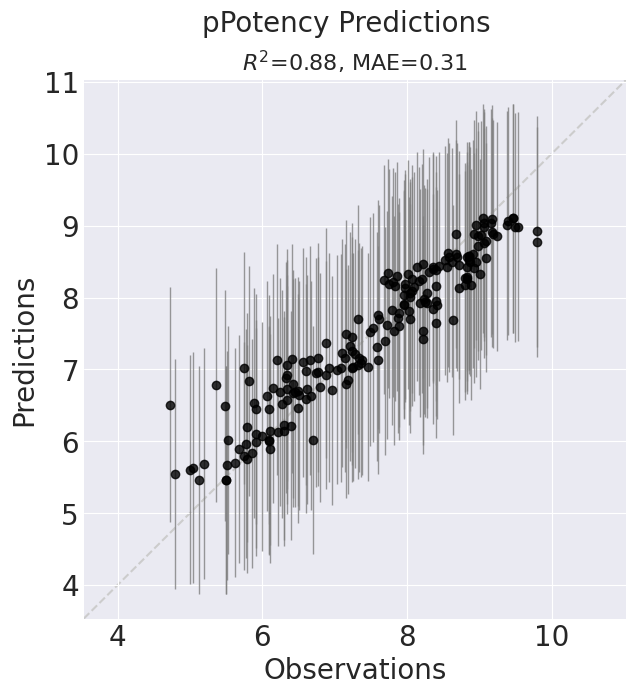

CPU times: user 35min 50s, sys: 6.2 s, total: 35min 56s
Wall time: 36min 15s


In [13]:
%%time

art = RecommendationEngine(df=LassaVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [40]:
LassaVirus_EnamineDatasets_wMACAW = pd.read_csv(resultsDir + "LassaVirus/LassaVirus_EnamineDatasets_wMACAW.csv")
LassaVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,0.082020,-0.100465,0.143736,0.012740,0.010961,0.034782,0.041563,-0.032900,-0.020971,-0.000958,0.031229,0.015966,0.041176,-0.002662,0.016790
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,0.110920,-0.062487,0.108433,0.032981,-0.039760,-0.000335,-0.009922,0.009645,0.010525,-0.055608,0.047151,-0.017454,-0.003200,0.042763,0.036375
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,0.135705,0.005716,0.107870,-0.023721,0.000330,-0.046364,-0.052455,-0.018845,0.032016,0.029700,0.073718,0.022457,0.004791,-0.003916,-0.002170
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,0.125130,-0.015689,0.147605,-0.044931,-0.013717,-0.020783,0.014473,0.011219,0.054396,0.018218,0.074911,0.040849,0.004347,0.019274,-0.003567
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,0.116205,0.003637,0.096678,-0.010097,-0.044401,-0.053487,-0.046328,-0.015374,0.020764,0.008956,0.042524,-0.004966,-0.068105,0.001894,0.041399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,0.122703,-0.053339,0.078719,-0.026166,-0.026777,-0.013018,-0.007125,0.056246,0.053611,0.009724,0.016342,0.017610,0.036314,0.003301,-0.013848
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,0.079400,-0.127978,0.121401,0.068619,0.005302,0.024694,-0.021394,-0.012761,-0.016283,-0.032004,0.004334,0.012093,0.006931,0.031921,0.003378
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,0.093414,-0.027335,0.166525,-0.010139,-0.013965,-0.020281,-0.003219,-0.010655,0.024015,-0.021427,0.036737,0.035243,0.042036,0.014781,0.020752
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,0.101787,-0.055251,0.125122,0.017768,0.018676,-0.030625,-0.038678,0.041798,0.064676,0.007268,0.019264,0.023452,0.001084,-0.000888,-0.011099


In [41]:
macaw_columns = [col for col in LassaVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = LassaVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [42]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

array([[6.29890211],
       [6.65898599],
       [6.51299603],
       ...,
       [6.29504629],
       [6.36959961],
       [6.25684406]])

Get predictions with uncertainty using ART's post_pred_stats

In [43]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = LassaVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,6.298902,0.620992,5.081757,7.516047,5.024558e-07,3.047566e-08,0.000008
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,6.658986,0.630087,5.424016,7.893956,2.192876e-07,1.276567e-08,0.000004
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,6.512996,0.620498,5.296820,7.729172,3.069050e-07,1.865640e-08,0.000005
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,6.257500,0.620669,5.040989,7.474011,5.527133e-07,3.357293e-08,0.000009
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,6.340685,0.621176,5.123181,7.558190,4.563675e-07,2.765734e-08,0.000008
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,6.202900,0.621296,4.985159,7.420641,6.267585e-07,3.796288e-08,0.000010
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,6.219996,0.622156,5.000570,7.439422,6.025654e-07,3.635618e-08,0.000010
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,6.295046,0.622252,5.075432,7.514661,5.069367e-07,3.057307e-08,0.000008
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,6.369600,0.625549,5.143524,7.595675,4.269730e-07,2.537026e-08,0.000007


## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [23]:
LassaVirus_LCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "LassaVirus/LassaVirus_LCAntiviralsData_wMACAW.csv")
LassaVirus_LCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,0.155913,-0.045744,0.110559,0.002273,-0.049545,-0.000155,-0.050379,0.081141,0.091151,-0.061133,-0.036789,-0.026429,0.074560,0.019951,-0.014121
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,0.119055,-0.047126,0.150950,0.050873,0.005875,-0.029196,0.001593,0.015130,0.047205,-0.047096,0.022228,0.009269,-0.014697,0.034522,0.039981
2,CN1CCCN(Cc2ccncc2)CC1,0.176150,-0.057366,0.162949,0.004054,-0.011899,-0.092958,-0.054630,0.000604,0.033689,-0.023275,0.083238,-0.019107,-0.012235,-0.020442,0.011156
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,0.118600,-0.051740,0.176096,0.014230,-0.000665,-0.019867,0.007595,0.001142,0.034549,-0.015329,0.044334,0.035623,-0.006987,-0.005601,0.021963
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,0.142830,-0.063906,0.137392,0.028272,-0.028609,-0.012304,-0.011656,0.038705,0.066649,-0.047569,0.046637,-0.005838,0.063475,-0.007665,0.014434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,0.131131,-0.145515,-0.026163,0.010015,0.003075,-0.073784,-0.079646,-0.143738,-0.071982,0.000054,-0.041375,-0.039820,-0.007470,-0.026053,0.012707
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,0.123032,-0.092826,-0.005901,-0.020741,-0.012473,-0.021004,-0.078767,-0.078400,-0.048172,-0.010943,-0.015554,-0.055785,-0.004707,-0.027033,0.053693
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,0.099571,-0.162602,0.029190,0.000312,0.036445,0.073092,-0.015629,-0.088459,-0.081121,-0.060683,0.026002,-0.006778,-0.005650,0.003127,0.012199
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,-0.010326,-0.034714,-0.075142,-0.027497,0.001881,-0.048947,-0.007673,-0.036970,-0.065731,-0.057935,0.003311,0.017579,0.011322,0.030052,0.031329


In [24]:
macaw_columns = [col for col in LassaVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = LassaVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [27]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

array([[6.16454829],
       [6.68238065],
       [6.8094834 ],
       ...,
       [5.82277071],
       [5.4869095 ],
       [5.49143283]])

Get predictions with uncertainty using ART's post_pred_stats

In [25]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = LassaVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,6.164548,0.631735,4.926347,7.402750,6.846234e-07,3.955947e-08,0.000012
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,6.682381,0.626951,5.453557,7.911205,2.077875e-07,1.226861e-08,0.000004
2,CN1CCCN(Cc2ccncc2)CC1,6.809483,0.622044,5.590277,8.028690,1.550660e-07,9.360744e-09,0.000003
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,6.492965,0.622092,5.273665,7.712266,3.213918e-07,1.939698e-08,0.000005
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,6.751857,0.626224,5.524457,7.979257,1.770692e-07,1.048922e-08,0.000003
...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,5.829001,0.627330,4.599435,7.058567,1.482514e-06,8.738420e-08,0.000025
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,5.963305,0.623413,4.741415,7.185194,1.088167e-06,6.528390e-08,0.000018
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,5.822771,0.625001,4.597768,7.047773,1.503936e-06,8.958322e-08,0.000025
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,5.486909,0.623869,4.264126,6.709693,3.259046e-06,1.951224e-07,0.000054


## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [28]:
LassaVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(resultsDir + "LassaVirus/LassaVirus_ChemDivAntiviralsData_wMACAW.csv")
LassaVirus_ChemDivAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,0.070883,-0.077209,-0.020050,-0.046271,0.003233,0.058087,-0.040949,-0.076302,-0.027224,0.015903,0.000966,0.038404,0.008111,0.039989,0.014865
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,0.098647,0.035912,0.054482,-0.004512,0.004029,-0.012235,-0.035207,-0.042971,0.015112,-0.041345,0.016689,0.060375,0.013531,0.026421,0.009717
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,0.038312,-0.103728,-0.007329,-0.090206,-0.000419,0.074006,-0.077254,-0.042920,-0.060767,0.010184,0.018084,0.071349,0.038545,-0.001507,0.015244
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,0.086214,-0.090557,-0.044469,0.036122,-0.034977,0.047871,0.022456,-0.089353,-0.017279,-0.023042,0.043993,0.076279,0.009741,0.022643,-0.003763
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,0.124068,-0.048389,-0.081415,-0.012008,-0.063597,-0.029713,0.012759,-0.006997,0.029818,-0.020745,-0.014694,0.064793,0.009529,0.057108,0.013934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64952,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,-0.014708,-0.023678,-0.042269,-0.012572,0.048320,0.024593,0.036636,-0.078293,0.027652,-0.061390,0.007826,0.092330,0.026934,0.063545,0.013785
64953,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,0.011333,-0.030755,-0.058415,0.021872,0.033820,0.013211,0.064429,-0.089785,0.027459,-0.040338,0.006130,0.096573,0.016943,0.076234,0.011983
64954,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,0.019587,-0.028007,-0.025544,0.006491,0.052387,0.009920,0.048108,-0.059682,0.013113,-0.039401,0.017638,0.093958,0.027297,0.055503,-0.002835
64955,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,-0.045474,-0.110141,0.001995,-0.003170,0.022215,0.036916,-0.003149,-0.139283,-0.022820,-0.045319,0.015548,0.098574,0.025973,0.064459,-0.026039


In [29]:
macaw_columns = [col for col in LassaVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = LassaVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [30]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.70298777],
       [6.06922189],
       [5.79347222],
       ...,
       [5.58828678],
       [5.37233809],
       [5.50309982]])

Get predictions with uncertainty using ART's post_pred_stats

In [31]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = LassaVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,5.702988,0.621037,4.485755,6.920220,1.981583e-06,1.201654e-07,0.000033
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,6.069222,0.619949,4.854122,7.284322,8.526644e-07,5.196110e-08,0.000014
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,5.793472,0.622802,4.572781,7.014164,1.608895e-06,9.679131e-08,0.000027
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,5.601173,0.626528,4.373178,6.829168,2.505112e-06,1.481945e-07,0.000042
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,5.611621,0.619370,4.397657,6.825586,2.445562e-06,1.494218e-07,0.000040
...,...,...,...,...,...,...,...,...
64952,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,5.285796,0.624735,4.061317,6.510276,5.178496e-06,3.088332e-07,0.000087
64953,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,5.303513,0.625866,4.076815,6.530211,4.971498e-06,2.949777e-07,0.000084
64954,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,5.588287,0.621727,4.369702,6.806872,2.580556e-06,1.560014e-07,0.000043
64955,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,5.372338,0.631910,4.133795,6.610882,4.242891e-06,2.449731e-07,0.000073


### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [32]:
LassaVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "LassaVirus/LassaVirus_SMACCAntiviralsData_wMACAW.csv")
LassaVirus_SMACCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,0.098952,-0.124479,0.071591,0.088976,-0.025260,0.044669,0.021125,-0.042161,-0.049902,-0.046267,0.041112,0.027760,0.024171,0.036247,0.026740
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,0.086062,-0.149940,-0.063340,0.027041,-0.092983,0.073203,0.057456,-0.070620,-0.087893,-0.028668,0.003269,-0.019475,0.058035,0.035082,-0.006602
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,0.100795,-0.099732,0.075181,0.033028,0.027994,0.022099,0.007620,-0.034822,-0.051179,-0.053823,0.080565,0.038043,0.051682,0.035797,0.024319
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,0.139150,-0.113785,0.115682,0.064416,0.017073,0.014047,0.020492,-0.025345,-0.055725,-0.050003,0.108182,-0.093492,0.025400,0.018699,0.021809
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,0.058186,-0.080154,-0.012905,0.043961,-0.070641,-0.006800,0.034505,-0.071853,-0.092345,-0.025489,0.039496,0.056678,0.067462,0.068354,0.015513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,0.117577,-0.146128,0.116178,0.084540,0.043221,0.025525,0.042784,-0.040252,-0.012280,-0.041871,0.091005,-0.020149,0.058091,-0.012801,0.004592
1608,S=C1Nc2ccccc2S1,0.124207,-0.126417,0.131339,0.077009,0.047711,0.023646,0.032216,-0.020495,-0.030363,-0.053411,0.091174,-0.061118,0.056746,0.014210,0.014948
1609,SC(=S)N1CCCC1,0.103044,-0.058214,0.163883,0.005912,0.013031,-0.009872,0.035573,-0.010833,-0.007538,-0.020932,0.051322,-0.039886,0.016819,0.016251,0.012564
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,0.146140,-0.170625,0.090375,0.075413,0.064715,-0.027499,0.010340,-0.098256,-0.044232,-0.074933,0.071427,-0.030234,0.042147,-0.000322,0.027910


In [33]:
macaw_columns = [col for col in LassaVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = LassaVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [34]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

array([[6.04335289],
       [5.4599522 ],
       [6.45388406],
       ...,
       [6.39933245],
       [6.6089701 ],
       [6.32503457]])

Get predictions with uncertainty using ART's post_pred_stats

In [35]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = LassaVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,6.043353,0.620912,4.826365,7.260341,9.049969e-07,5.491100e-08,0.000015
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,5.459952,0.628026,4.229022,6.690883,3.467750e-06,2.037592e-07,0.000059
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,6.453884,0.620372,5.237956,7.669812,3.516543e-07,2.138886e-08,0.000006
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,7.167375,0.629619,5.933320,8.401429,6.801825e-08,3.967996e-09,0.000001
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,5.777709,0.625777,4.551185,7.004233,1.668364e-06,9.903006e-08,0.000028
...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,6.780524,0.624807,5.555903,8.005145,1.657584e-07,9.882224e-09,0.000003
1608,S=C1Nc2ccccc2S1,6.906896,0.624566,5.682746,8.131046,1.239093e-07,7.395272e-09,0.000002
1609,SC(=S)N1CCCC1,6.399332,0.620055,5.184024,7.614641,3.987196e-07,2.428618e-08,0.000007
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,6.608970,0.622694,5.388489,7.829451,2.460537e-07,1.480980e-08,0.000004


### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [36]:
LassaVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(resultsDir + "LassaVirus/LassaVirus_DTRA_smiles_wMACAW.csv")
LassaVirus_DTRA_target_antivirals_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,0.065101,-0.356578,0.129292,0.124095,-0.190408,0.104347,-0.038369,0.026405,-0.054394,0.063998,-0.124171,-0.044790,0.113119,0.032709,0.025625
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,-0.170537,-0.125916,-0.018620,0.019489,-0.059031,-0.039011,0.043981,-0.020385,-0.009092,0.017552,-0.007888,-0.020689,-0.015480,0.039142,0.006917


In [37]:
macaw_columns = [col for col in LassaVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = LassaVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [38]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

array([[6.37854644],
       [5.20872978]])

Get predictions with uncertainty using ART's post_pred_stats

In [39]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = LassaVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "LassaVirus/LassaVirus_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,6.378546,0.620060,5.163229,7.593864,4.182670e-07,2.547627e-08,0.000007
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,5.208730,0.619263,3.994973,6.422486,6.184010e-06,3.780192e-07,0.000101


### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [ ]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES